In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns
plt.style.use("ggplot")
sns.set_style("whitegrid")
set_matplotlib_formats("svg")

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [6]:
def visa_utveckling(refk="Karlstad", refy=1950, minp=0.8, maxp=1.2):
    _ = befolkning.div(befolkning.loc[refk,refy]).sort_values(refy)
    kommuner = _.loc[(_[refy]>0.80)&(_[refy]<1.2)].index
    colors = sns.color_palette("Set2") + sns.color_palette("Dark2")
    cmap = dict(zip(sorted(kommuner), colors[0:len(kommuner)]))
    ax = sns.lineplot(data=befm, hue="Kommun", hue_order=sorted(kommuner), palette=cmap, x="År", y="befolkning")
    ax.legend(bbox_to_anchor=(1.5,1))
    for k in kommuner:
        y = befm.loc[(befm.Kommun==k)&(befm["År"]==2021), "befolkning"]
        ax.text(2022, y, k, color=cmap[k])

def visa_forandring(minp=-.05, maxp=.05):
    m = pct.mean(axis=1).sort_values()
    kommuner = m.loc[(m>-0.05)&(m<0.05)].index
    ax = sns.lineplot(data=befm, hue="Kommun", hue_order=kommuner, x="År", y="befolkning")
    ax.legend(bbox_to_anchor=(1.5,1))
    return ax

def visa_framtid(kommuner=["Karlstad"], start=2021, stopp=2122, perc=1):
    inc = 1+perc/100
    d = {}
    for kommun in kommuner:
        startb = befolkning.loc[kommun, start]
        d[kommun] = {start: startb}
        for y in list(range(start+1, stopp+1)):
            d[kommun][y] = d[kommun][y-1]*inc
    framtid = pd.DataFrame(d).T
    return framtid

def ta_bort_extremer(X=10):
    for r in resultat.index:
        for y in resultat.columns:
            if resultat.loc[r, y] > X * m[r]:
                resultat.loc[r, y] = np.nan
    return resultat

In [4]:
befolkning = pd.read_csv("SCB_folkmangd_1950-2021.csv", header=0,sep=",", index_col=0)
befolkning.rename(columns=lambda x: int(x), inplace=True)
befm = pd.melt(befolkning.reset_index(), id_vars=["Kommun"], var_name="År", value_name="befolkning")

In [5]:
intakter = pd.read_csv("SCB_intakter.csv", header=0, sep=",", index_col=0)
intakter.rename(columns = lambda x: int(x), inplace=True)
intakterm = pd.melt(intakter.reset_index(), id_vars="region", value_name="Tkr/person", var_name="År")

In [7]:
resultat = pd.read_csv("SCB_resultat.csv", sep=",", header=0, index_col=0)
resultat.rename(columns= lambda x: int(x), inplace=True)
m = pd.DataFrame(resultat.median(axis=1)).to_dict()[0]
# Ta bort 'outliers' definierat som värden som är X ggr större än medianen för varje kommun
resultat = ta_bort_extremer(X=10)
resultatm = pd.melt(resultat.reset_index(), id_vars="region", value_name="Tkr/person", var_name="År")

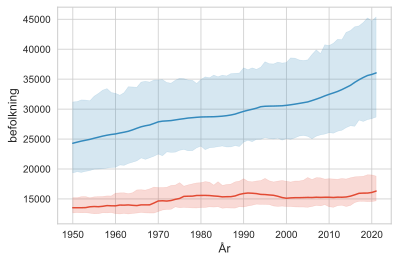

In [102]:
ax = sns.lineplot(data=befm, x="År", y="befolkning", estimator=np.median);
ax = sns.lineplot(data=befm, x="År", y="befolkning", estimator=np.mean, ax=ax);

Ovan: Medelvärde för befolkning i blått, medianvärde i rött. Alla kommuner.

Här sätter vi startåret till 1950 och visar utvecklingen för alla kommuner som ligger inom 20% av Karlstads befolkningsmängd det året.

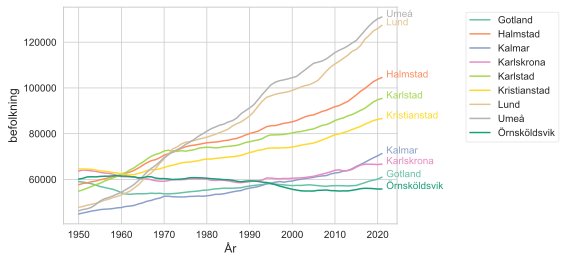

In [108]:
visa_utveckling(refk="Karlstad", refy=1950, minp=0.8, maxp=1.2)

Måste kommuner växa för att inte krympa?

Här räknar vi ut förändringen i befolkningsmängd för varje kommun, uttryckt i procent.

In [117]:
pct = {}
for y in befolkning.columns[1:]:
    pct[y] = (befolkning[y]-befolkning[y-1])/befolkning[y]*100
pct = pd.DataFrame(pct)
pctm = pd.melt(pct.reset_index(), id_vars="Kommun", var_name="År", value_name="f%")

Så här ser trenden ut för alla kommuner inräknat.

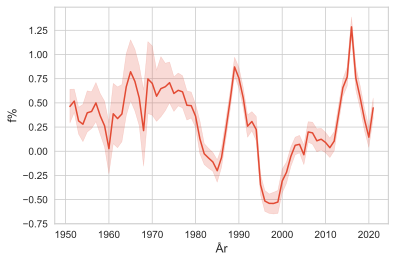

In [122]:
ax = sns.lineplot(data=pctm, x="År", y="f%");

Här syns relativt tydligt bl.a. en babyboom i mitten på [60-talet](https://sv.wikipedia.org/wiki/Babyboom#Cirka_1965_till_1975) samt i slutet på [80-talet](https://sv.wikipedia.org/wiki/Babyboom#Cirka_1989_till_1993).

Kommuners befolkning kan växa eller krympa, eller faktiskt stå stilla. Låt oss se vilka kommuner som har legat på ungefär samma befolkningsmängd sedan 1950. Vi gör detta genom att räkna ut ett medelvärde för befolkningsförändringen för varje kommun, sedan ser vi efter vilka kommuner som har ett medelvärde på mellan -0.05% till +0.05%.

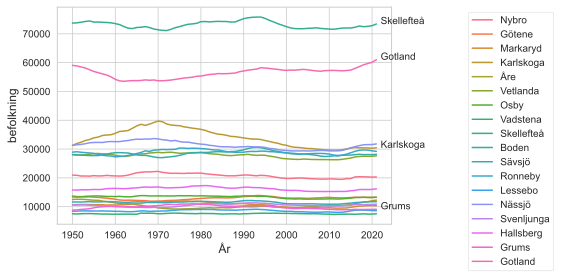

In [249]:
ax = visa_forandring(minp=-.05, maxp=.05)
kommun = ["Skellefteå", "Gotland", "Grums", "Karlskoga"]
for k in kommun:
    ax.text(x=2022, y=befolkning.loc[k, 2021], s=k)

Det verkar med andra ord finnas gott om kommuner som varken växer eller krymper.

Nedan visar vi intäkter (i tusen kr / person) för ett urval av kommunerna.

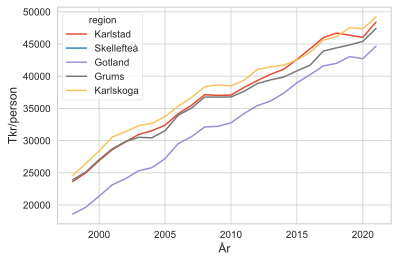

In [250]:
sns.lineplot(data=intakterm, x="År", y="Tkr/person", hue="region", hue_order=["Karlstad", "Skellefteå", "Gotland", "Grums", "Karlskoga"]);

Skatteintäkterna per person verkar öka varje år både för kommuner som står stilla i befolkningsmängd, och för exempelvis Karlstad.

Ett mer rättvisande sätt att räkna är förstås att dra bort kommunernas utgifter från intäkterna, så det visas nedan.

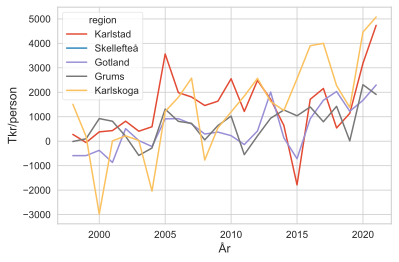

In [251]:
ax = sns.lineplot(data=resultatm, x="År", y="Tkr/person", hue="region", hue_order=["Karlstad", "Skellefteå", "Gotland", "Grums", "Karlskoga"])

Även här verkar det som att det är fullt möjligt att inte växa i befolkning men ändå ha ett positivt resultat i budgeten.

## Om Karlstad växer med 1% per år

Så vad skulle hända om vi tar Karlstads mål att växa befolkningen med minst 1% per år och låter det gå några generationer?

<AxesSubplot:xlabel='År', ylabel='befolkning'>

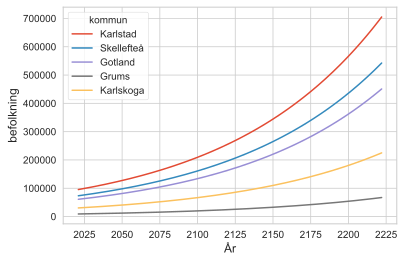

In [278]:
kommuner = ["Karlstad", "Skellefteå", "Gotland", "Grums", "Karlskoga"]
framtid = visa_framtid(kommuner=kommuner, start=2021, stopp=2222)
framtid.index.name="kommun"
framtidm = pd.melt(framtid.reset_index(), id_vars=["kommun"], value_name="befolkning", var_name="År", )
sns.lineplot(data=framtidm, x="År", y="befolkning", hue="kommun", hue_order = kommuner);

Om Karlstad och dessa ytterligare fyra kommuner hade 1% ökning som mål skulle de alltså inom 200 år växa från under 100 000 personer vardera till ca 2 miljoner personer sammantaget. Karlstad skulle på egen hand börja närma sig Stockholm i folkmängd.